In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 512)
        self.z_log_var = nn.Linear(2048, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Unflatten(1, (2048, 1, 1)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=(-1, 1), translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=128, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
704 704 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 94.44it/s]


Epoch: 0 - TrainRecLoss: 2233.3407041376286 - ValidRecLoss: 1820.7372720891778
Epoch: 0 - TrainDivLoss: 157.0992749929428 - ValidDivLoss: 81.94052041660656


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.22it/s]


Epoch: 1 - TrainRecLoss: 1655.7083502682772 - ValidRecLoss: 1553.864666331898
Epoch: 1 - TrainDivLoss: 64.60566031932831 - ValidDivLoss: 55.30074546012011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.57it/s]


Epoch: 2 - TrainRecLoss: 1515.8028512434526 - ValidRecLoss: 1462.4434583837335
Epoch: 2 - TrainDivLoss: 54.82616654309359 - ValidDivLoss: 53.63091013648293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 94.22it/s]


Epoch: 3 - TrainRecLoss: 1429.4750040227716 - ValidRecLoss: 1410.3855983560736
Epoch: 3 - TrainDivLoss: 54.767672674222425 - ValidDivLoss: 54.780355090444736


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 95.88it/s]


Epoch: 4 - TrainRecLoss: 1370.5869086872447 - ValidRecLoss: 1344.8519965952094
Epoch: 4 - TrainDivLoss: 54.14041468230161 - ValidDivLoss: 54.9463966217908


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.91it/s]


Epoch: 5 - TrainRecLoss: 1336.7264003753662 - ValidRecLoss: 1316.4588749625466
Epoch: 5 - TrainDivLoss: 53.540582060813904 - ValidDivLoss: 52.819078315388076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.67it/s]


Epoch: 6 - TrainRecLoss: 1313.7776936617765 - ValidRecLoss: 1336.2766839807684
Epoch: 6 - TrainDivLoss: 53.7346984798258 - ValidDivLoss: 56.76145599647002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.94it/s]


Epoch: 7 - TrainRecLoss: 1301.414740302346 - ValidRecLoss: 1288.4398028633811
Epoch: 7 - TrainDivLoss: 52.16318689151244 - ValidDivLoss: 51.49485646594655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.73it/s]


Epoch: 8 - TrainRecLoss: 1288.5934940684926 - ValidRecLoss: 1265.6029712503607
Epoch: 8 - TrainDivLoss: 50.92707513679158 - ValidDivLoss: 52.58266746997833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.01it/s]


Epoch: 9 - TrainRecLoss: 1265.2883503653786 - ValidRecLoss: 1250.4934270165184
Epoch: 9 - TrainDivLoss: 53.19051290642131 - ValidDivLoss: 52.388584873893045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.84it/s]


Epoch: 10 - TrainRecLoss: 1248.245914806019 - ValidRecLoss: 1229.709457917647
Epoch: 10 - TrainDivLoss: 53.815882764079355 - ValidDivLoss: 53.34562809358943


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.23it/s]


Epoch: 11 - TrainRecLoss: 1229.9465923309326 - ValidRecLoss: 1202.836169242859
Epoch: 11 - TrainDivLoss: 54.9836920987476 - ValidDivLoss: 55.482761361382224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.65it/s]


Epoch: 12 - TrainRecLoss: 1206.9675861705434 - ValidRecLoss: 1180.857710578225
Epoch: 12 - TrainDivLoss: 56.79301110180941 - ValidDivLoss: 56.56827527826483


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.10it/s]


Epoch: 13 - TrainRecLoss: 1191.0990500016646 - ValidRecLoss: 1180.4133410020308
Epoch: 13 - TrainDivLoss: 55.53550100868399 - ValidDivLoss: 56.93697159398686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.91it/s]


Epoch: 14 - TrainRecLoss: 1185.8287692503495 - ValidRecLoss: 1168.588571028276
Epoch: 14 - TrainDivLoss: 55.790874188596554 - ValidDivLoss: 55.296710382808335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.90it/s]


Epoch: 15 - TrainRecLoss: 1171.5913425792348 - ValidRecLoss: 1149.3759110190651
Epoch: 15 - TrainDivLoss: 57.79266048561443 - ValidDivLoss: 57.65942714431069


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.52it/s]


Epoch: 16 - TrainRecLoss: 1161.220647465099 - ValidRecLoss: 1152.6605343385177
Epoch: 16 - TrainDivLoss: 59.1464050303806 - ValidDivLoss: 59.859900550408796


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.96it/s]


Epoch: 17 - TrainRecLoss: 1155.3968679254706 - ValidRecLoss: 1139.4630918502808
Epoch: 17 - TrainDivLoss: 58.95713445273313 - ValidDivLoss: 60.09838327494535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.15it/s]


Epoch: 18 - TrainRecLoss: 1154.0532627105713 - ValidRecLoss: 1139.4215980876577
Epoch: 18 - TrainDivLoss: 59.348453337495975 - ValidDivLoss: 59.424613855101846


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.07it/s]


Epoch: 19 - TrainRecLoss: 1149.2199667150323 - ValidRecLoss: 1135.0419210954146
Epoch: 19 - TrainDivLoss: 59.14084409041838 - ValidDivLoss: 58.595902703025125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.59it/s]


Epoch: 20 - TrainRecLoss: 1143.6132966821845 - ValidRecLoss: 1126.604810628024
Epoch: 20 - TrainDivLoss: 58.57974993098866 - ValidDivLoss: 59.26396305452693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.23it/s]


Epoch: 21 - TrainRecLoss: 1135.7248080860484 - ValidRecLoss: 1116.4827399687333
Epoch: 21 - TrainDivLoss: 58.76213852925734 - ValidDivLoss: 57.59770833362233


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.99it/s]


Epoch: 22 - TrainRecLoss: 1128.2449834997003 - ValidRecLoss: 1117.994146086953
Epoch: 22 - TrainDivLoss: 57.85631242665377 - ValidDivLoss: 58.26338416337967


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.41it/s]


Epoch: 23 - TrainRecLoss: 1124.8875923156738 - ValidRecLoss: 1110.7141277139838
Epoch: 23 - TrainDivLoss: 57.5575728579001 - ValidDivLoss: 57.231180521574885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.88it/s]


Epoch: 24 - TrainRecLoss: 1119.5718073411422 - ValidRecLoss: 1100.476378440857
Epoch: 24 - TrainDivLoss: 58.88642225482247 - ValidDivLoss: 60.52656398578124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.56it/s]


Epoch: 25 - TrainRecLoss: 1109.03298256614 - ValidRecLoss: 1093.09890313582
Epoch: 25 - TrainDivLoss: 60.09521087191322 - ValidDivLoss: 61.42593161626296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.04it/s]


Epoch: 26 - TrainRecLoss: 1107.079911145297 - ValidRecLoss: 1092.7492024681785
Epoch: 26 - TrainDivLoss: 60.55135760524056 - ValidDivLoss: 60.23496088656512


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 27 - TrainRecLoss: 1103.6173406947744 - ValidRecLoss: 1115.6826649579134
Epoch: 27 - TrainDivLoss: 61.29195135289972 - ValidDivLoss: 64.71333844553341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 28 - TrainRecLoss: 1100.138875094327 - ValidRecLoss: 1085.8048054088247
Epoch: 28 - TrainDivLoss: 63.04530991207469 - ValidDivLoss: 61.68463756279512


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.21it/s]


Epoch: 29 - TrainRecLoss: 1092.7010845704513 - ValidRecLoss: 1084.4877020228994
Epoch: 29 - TrainDivLoss: 62.251309817487545 - ValidDivLoss: 62.917013282125644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.13it/s]


Epoch: 30 - TrainRecLoss: 1091.7512070915916 - ValidRecLoss: 1082.2631743170998
Epoch: 30 - TrainDivLoss: 62.39170405539599 - ValidDivLoss: 62.75674764134667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 31 - TrainRecLoss: 1088.943361195651 - ValidRecLoss: 1073.244766148654
Epoch: 31 - TrainDivLoss: 62.33880496566946 - ValidDivLoss: 61.69574705579064


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.06it/s]


Epoch: 32 - TrainRecLoss: 1085.8974633650346 - ValidRecLoss: 1069.1957146904685
Epoch: 32 - TrainDivLoss: 61.967573355544694 - ValidDivLoss: 62.660774545236066


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.23it/s]


Epoch: 33 - TrainRecLoss: 1084.8791828155518 - ValidRecLoss: 1071.4947055469859
Epoch: 33 - TrainDivLoss: 62.055814076553695 - ValidDivLoss: 62.1767487634312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.12it/s]


Epoch: 34 - TrainRecLoss: 1083.465482451699 - ValidRecLoss: 1072.914516102184
Epoch: 34 - TrainDivLoss: 62.038226490670986 - ValidDivLoss: 61.67615814100612


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.29it/s]


Epoch: 35 - TrainRecLoss: 1081.3716633536599 - ValidRecLoss: 1068.1078590046275
Epoch: 35 - TrainDivLoss: 62.060620882294394 - ValidDivLoss: 61.72982416369698


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.11it/s]


Epoch: 36 - TrainRecLoss: 1081.4553109949286 - ValidRecLoss: 1067.4656417153099
Epoch: 36 - TrainDivLoss: 62.062243873422794 - ValidDivLoss: 61.358815182339065


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.17it/s]


Epoch: 37 - TrainRecLoss: 1076.2672823992643 - ValidRecLoss: 1061.0868463516235
Epoch: 37 - TrainDivLoss: 62.660066815939814 - ValidDivLoss: 63.028692267157815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.63it/s]


Epoch: 38 - TrainRecLoss: 1072.899622223594 - ValidRecLoss: 1058.8703280362215
Epoch: 38 - TrainDivLoss: 63.439572670243 - ValidDivLoss: 62.956685131246395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 39 - TrainRecLoss: 1068.6182991374624 - ValidRecLoss: 1057.555719722401
Epoch: 39 - TrainDivLoss: 62.82291394472122 - ValidDivLoss: 62.2435564994812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.75it/s]


Epoch: 40 - TrainRecLoss: 1067.1479666449807 - ValidRecLoss: 1056.785724813288
Epoch: 40 - TrainDivLoss: 62.70956854928624 - ValidDivLoss: 63.55340684002096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.55it/s]


Epoch: 41 - TrainRecLoss: 1066.441211006858 - ValidRecLoss: 1057.6391413428566
Epoch: 41 - TrainDivLoss: 62.99952102249319 - ValidDivLoss: 62.999968566677786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.86it/s]


Epoch: 42 - TrainRecLoss: 1065.4281218268654 - ValidRecLoss: 1056.1163311871614
Epoch: 42 - TrainDivLoss: 62.79300023750825 - ValidDivLoss: 62.30983873930845


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.15it/s]


Epoch: 43 - TrainRecLoss: 1063.7454940622504 - ValidRecLoss: 1051.6933495781639
Epoch: 43 - TrainDivLoss: 62.641395471312784 - ValidDivLoss: 61.793886688622564


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.24it/s]


Epoch: 44 - TrainRecLoss: 1063.0528959794478 - ValidRecLoss: 1051.9862757596102
Epoch: 44 - TrainDivLoss: 62.80622358755632 - ValidDivLoss: 62.59352938153527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.87it/s]


Epoch: 45 - TrainRecLoss: 1062.2509829781272 - ValidRecLoss: 1052.2960969751532
Epoch: 45 - TrainDivLoss: 62.88866741548885 - ValidDivLoss: 63.155013127760455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.63it/s]


Epoch: 46 - TrainRecLoss: 1060.9628542986784 - ValidRecLoss: 1050.6488209637728
Epoch: 46 - TrainDivLoss: 63.17512854662809 - ValidDivLoss: 63.16570038145239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.20it/s]


Epoch: 47 - TrainRecLoss: 1057.6467840888283 - ValidRecLoss: 1045.4209410927513
Epoch: 47 - TrainDivLoss: 63.73553638024764 - ValidDivLoss: 64.07087929140438


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.87it/s]


Epoch: 48 - TrainRecLoss: 1054.5379196513784 - ValidRecLoss: 1044.6465556404808
Epoch: 48 - TrainDivLoss: 63.90654334696856 - ValidDivLoss: 64.07563398101114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.06it/s]


Epoch: 49 - TrainRecLoss: 1054.4194984436035 - ValidRecLoss: 1045.6099356738005
Epoch: 49 - TrainDivLoss: 64.37841408902949 - ValidDivLoss: 64.48153378204866


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.67it/s]


Epoch: 50 - TrainRecLoss: 1052.7820959958162 - ValidRecLoss: 1043.77823231437
Epoch: 50 - TrainDivLoss: 64.07850338112225 - ValidDivLoss: 63.442933727394454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.13it/s]


Epoch: 51 - TrainRecLoss: 1051.1370766379616 - ValidRecLoss: 1039.9426116076384
Epoch: 51 - TrainDivLoss: 64.25603706186467 - ValidDivLoss: 63.7216522639448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.74it/s]


Epoch: 52 - TrainRecLoss: 1049.6552448272705 - ValidRecLoss: 1042.6113891601562
Epoch: 52 - TrainDivLoss: 63.87440577962182 - ValidDivLoss: 63.165468010035426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.13it/s]


Epoch: 53 - TrainRecLoss: 1049.1975815512917 - ValidRecLoss: 1042.8258180618286
Epoch: 53 - TrainDivLoss: 63.97656906734813 - ValidDivLoss: 63.71674459088933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.87it/s]


Epoch: 54 - TrainRecLoss: 1048.5122465653853 - ValidRecLoss: 1041.045884999362
Epoch: 54 - TrainDivLoss: 64.05822995575991 - ValidDivLoss: 64.33477693796158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.07it/s]


Epoch: 55 - TrainRecLoss: 1049.7564032294533 - ValidRecLoss: 1040.536373571916
Epoch: 55 - TrainDivLoss: 64.53964334726334 - ValidDivLoss: 63.88464078036222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.85it/s]


Epoch: 56 - TrainRecLoss: 1046.9608410054987 - ValidRecLoss: 1041.5445256666703
Epoch: 56 - TrainDivLoss: 63.9687115279111 - ValidDivLoss: 64.55046065829016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.03it/s]


Epoch: 57 - TrainRecLoss: 1046.3761537725275 - ValidRecLoss: 1040.8346142335372
Epoch: 57 - TrainDivLoss: 64.01583154634996 - ValidDivLoss: 63.51838426698338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.98it/s]


Epoch: 58 - TrainRecLoss: 1044.0497647198763 - ValidRecLoss: 1036.176593433727
Epoch: 58 - TrainDivLoss: 64.35326045209712 - ValidDivLoss: 64.70803100954403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.98it/s]


Epoch: 59 - TrainRecLoss: 1042.566283832897 - ValidRecLoss: 1035.105370868336
Epoch: 59 - TrainDivLoss: 64.9951387481256 - ValidDivLoss: 64.1541473919695


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 60 - TrainRecLoss: 1040.901760188016 - ValidRecLoss: 1034.2194607474587
Epoch: 60 - TrainDivLoss: 64.97005374865098 - ValidDivLoss: 65.56632520935752


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.73it/s]


Epoch: 61 - TrainRecLoss: 1039.9009459235451 - ValidRecLoss: 1033.217440778559
Epoch: 61 - TrainDivLoss: 65.09514308517629 - ValidDivLoss: 64.66082019155675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.64it/s]


Epoch: 62 - TrainRecLoss: 1038.2231785167348 - ValidRecLoss: 1028.2857257669623
Epoch: 62 - TrainDivLoss: 65.24429476261139 - ValidDivLoss: 65.09804030981931


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.01it/s]


Epoch: 63 - TrainRecLoss: 1035.1373003179376 - ValidRecLoss: 1028.2748986157503
Epoch: 63 - TrainDivLoss: 65.75800896232778 - ValidDivLoss: 66.1756807403131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.88it/s]


Epoch: 64 - TrainRecLoss: 1032.5632398778741 - ValidRecLoss: 1026.4887595610185
Epoch: 64 - TrainDivLoss: 65.92336537621237 - ValidDivLoss: 66.65337684479627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.90it/s]


Epoch: 65 - TrainRecLoss: 1031.6999437158759 - ValidRecLoss: 1022.9416127638383
Epoch: 65 - TrainDivLoss: 66.16641037030654 - ValidDivLoss: 66.79196386445652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 66 - TrainRecLoss: 1030.6138333407316 - ValidRecLoss: 1024.012708750638
Epoch: 66 - TrainDivLoss: 66.0437609390779 - ValidDivLoss: 66.57899262146516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.32it/s]


Epoch: 67 - TrainRecLoss: 1030.6327827627008 - ValidRecLoss: 1022.089916489341
Epoch: 67 - TrainDivLoss: 66.38299594142221 - ValidDivLoss: 65.29701842503114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.97it/s]


Epoch: 68 - TrainRecLoss: 1029.539846680381 - ValidRecLoss: 1021.0557510202581
Epoch: 68 - TrainDivLoss: 66.1750935424458 - ValidDivLoss: 66.32134992967953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.09it/s]


Epoch: 69 - TrainRecLoss: 1028.8585383675315 - ValidRecLoss: 1027.6890080191872
Epoch: 69 - TrainDivLoss: 66.03308289701289 - ValidDivLoss: 66.72152715921402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.15it/s]


Epoch: 70 - TrainRecLoss: 1030.1961889266968 - ValidRecLoss: 1022.5327842885798
Epoch: 70 - TrainDivLoss: 66.51834797859192 - ValidDivLoss: 65.9907950704748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.39it/s]


Epoch: 71 - TrainRecLoss: 1027.4720228368585 - ValidRecLoss: 1024.4529503042047
Epoch: 71 - TrainDivLoss: 65.82060142538764 - ValidDivLoss: 67.95605779777874


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.03it/s]


Epoch: 72 - TrainRecLoss: 1027.1266355514526 - ValidRecLoss: 1020.5910690481013
Epoch: 72 - TrainDivLoss: 65.64502009478483 - ValidDivLoss: 65.20329568602823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 73 - TrainRecLoss: 1026.3372245268388 - ValidRecLoss: 1017.9386840300126
Epoch: 73 - TrainDivLoss: 65.59884547103535 - ValidDivLoss: 65.16332751512527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.49it/s]


Epoch: 74 - TrainRecLoss: 1026.1963769739325 - ValidRecLoss: 1019.7004787271673
Epoch: 74 - TrainDivLoss: 65.51379705559124 - ValidDivLoss: 65.1551124887033


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.79it/s]


Epoch: 75 - TrainRecLoss: 1024.8534021377563 - ValidRecLoss: 1016.088117426092
Epoch: 75 - TrainDivLoss: 65.2410912622105 - ValidDivLoss: 65.01524937694722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.34it/s]


Epoch: 76 - TrainRecLoss: 1025.007405281067 - ValidRecLoss: 1017.9044189453125
Epoch: 76 - TrainDivLoss: 65.10809171199799 - ValidDivLoss: 64.62428644028577


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.05it/s]


Epoch: 77 - TrainRecLoss: 1023.9281138506802 - ValidRecLoss: 1018.912049813704
Epoch: 77 - TrainDivLoss: 65.18382010676645 - ValidDivLoss: 65.23415307023309


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.17it/s]


Epoch: 78 - TrainRecLoss: 1022.8181118531661 - ValidRecLoss: 1016.6677878986706
Epoch: 78 - TrainDivLoss: 65.06143812699752 - ValidDivLoss: 65.47045960209586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.49it/s]


Epoch: 79 - TrainRecLoss: 1022.8903826800259 - ValidRecLoss: 1018.124116897583
Epoch: 79 - TrainDivLoss: 65.25953412055969 - ValidDivLoss: 65.25227072564039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.48it/s]


Epoch: 80 - TrainRecLoss: 1022.4230187155983 - ValidRecLoss: 1013.9338545365767
Epoch: 80 - TrainDivLoss: 65.61486851085316 - ValidDivLoss: 65.02197453650561


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 81 - TrainRecLoss: 1019.4683361920444 - ValidRecLoss: 1011.6187493584373
Epoch: 81 - TrainDivLoss: 65.84541240605441 - ValidDivLoss: 65.505752352151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.11it/s]


Epoch: 82 - TrainRecLoss: 1018.4252790104259 - ValidRecLoss: 1012.6665697964755
Epoch: 82 - TrainDivLoss: 65.90157560868697 - ValidDivLoss: 65.96166989478198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.45it/s]


Epoch: 83 - TrainRecLoss: 1016.8564382032914 - ValidRecLoss: 1008.9603186520663
Epoch: 83 - TrainDivLoss: 66.38003126057711 - ValidDivLoss: 66.09049364653501


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.97it/s]


Epoch: 84 - TrainRecLoss: 1016.4362870996648 - ValidRecLoss: 1009.2547186071223
Epoch: 84 - TrainDivLoss: 66.15818389979276 - ValidDivLoss: 66.27773011814465


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.86it/s]


Epoch: 85 - TrainRecLoss: 1016.8773837523026 - ValidRecLoss: 1008.8647503419356
Epoch: 85 - TrainDivLoss: 66.40865402871913 - ValidDivLoss: 65.50820100307465


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.92it/s]


Epoch: 86 - TrainRecLoss: 1015.3350915041837 - ValidRecLoss: 1011.2643228010697
Epoch: 86 - TrainDivLoss: 66.29746827212247 - ValidDivLoss: 65.8203061060472


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.00it/s]


Epoch: 87 - TrainRecLoss: 1015.3065808903087 - ValidRecLoss: 1008.7414562051946
Epoch: 87 - TrainDivLoss: 67.21388322656804 - ValidDivLoss: 66.39679283987392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.73it/s]


Epoch: 88 - TrainRecLoss: 1011.8100938796997 - ValidRecLoss: 1010.90649023923
Epoch: 88 - TrainDivLoss: 66.85248603604056 - ValidDivLoss: 66.22916728799993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.49it/s]


Epoch: 89 - TrainRecLoss: 1010.3029520728371 - ValidRecLoss: 1004.5046762986617
Epoch: 89 - TrainDivLoss: 67.19848892905496 - ValidDivLoss: 66.46060092882676


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.46it/s]


Epoch: 90 - TrainRecLoss: 1008.4154039729725 - ValidRecLoss: 1001.4794679988514
Epoch: 90 - TrainDivLoss: 67.11435347253627 - ValidDivLoss: 67.05764052000913


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.81it/s]


Epoch: 91 - TrainRecLoss: 1008.1552618200129 - ValidRecLoss: 1002.772425738248
Epoch: 91 - TrainDivLoss: 67.27314616333355 - ValidDivLoss: 66.40494605086066


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.92it/s]


Epoch: 92 - TrainRecLoss: 1008.021393515847 - ValidRecLoss: 1002.4264343435115
Epoch: 92 - TrainDivLoss: 67.74549853801727 - ValidDivLoss: 67.41648121855475


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.91it/s]


Epoch: 93 - TrainRecLoss: 1007.2849625674161 - ValidRecLoss: 1001.5197073329579
Epoch: 93 - TrainDivLoss: 67.48787331581116 - ValidDivLoss: 66.52558612823486


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.07it/s]


Epoch: 94 - TrainRecLoss: 1006.2564252506603 - ValidRecLoss: 1001.0351582440463
Epoch: 94 - TrainDivLoss: 67.35475094751878 - ValidDivLoss: 67.49110322648829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.65it/s]


Epoch: 95 - TrainRecLoss: 1005.412053715099 - ValidRecLoss: 999.4965638247403
Epoch: 95 - TrainDivLoss: 67.23670715635473 - ValidDivLoss: 67.02945638244802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.98it/s]


Epoch: 96 - TrainRecLoss: 1005.626318324696 - ValidRecLoss: 1000.9849123521285
Epoch: 96 - TrainDivLoss: 67.34600003199144 - ValidDivLoss: 66.82524735277349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.11it/s]


Epoch: 97 - TrainRecLoss: 1004.5877717625011 - ValidRecLoss: 1000.0326132340865
Epoch: 97 - TrainDivLoss: 67.32273664257742 - ValidDivLoss: 67.29317558895458


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.24it/s]


Epoch: 98 - TrainRecLoss: 1005.36168384552 - ValidRecLoss: 999.767993406816
Epoch: 98 - TrainDivLoss: 67.33267800374465 - ValidDivLoss: 66.94122930006547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.33it/s]


Epoch: 99 - TrainRecLoss: 1004.5123331763527 - ValidRecLoss: 998.530929218639
Epoch: 99 - TrainDivLoss: 67.65734048323198 - ValidDivLoss: 66.93612278049642


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.15it/s]


Epoch: 100 - TrainRecLoss: 1003.4751751639626 - ValidRecLoss: 998.8161572543057
Epoch: 100 - TrainDivLoss: 67.30255949497223 - ValidDivLoss: 66.87990881096233


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.67it/s]


Epoch: 101 - TrainRecLoss: 1003.4010986848311 - ValidRecLoss: 999.5495923649181
Epoch: 101 - TrainDivLoss: 67.31106854568829 - ValidDivLoss: 67.09202934395184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.52it/s]


Epoch: 102 - TrainRecLoss: 1002.9628118168224 - ValidRecLoss: 999.5674104690552
Epoch: 102 - TrainDivLoss: 67.40561691197482 - ValidDivLoss: 66.74718683958054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.99it/s]


Epoch: 103 - TrainRecLoss: 1002.759747765281 - ValidRecLoss: 996.8370333584872
Epoch: 103 - TrainDivLoss: 67.53202884847468 - ValidDivLoss: 66.71915019100362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.28it/s]


Epoch: 104 - TrainRecLoss: 1002.1393996152011 - ValidRecLoss: 998.5849852128463
Epoch: 104 - TrainDivLoss: 67.41251186891036 - ValidDivLoss: 66.85568515279077


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.21it/s]


Epoch: 105 - TrainRecLoss: 1001.3637975345958 - ValidRecLoss: 997.5657393715599
Epoch: 105 - TrainDivLoss: 67.33048869263042 - ValidDivLoss: 66.5813716324893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.55it/s]


Epoch: 106 - TrainRecLoss: 1001.3166254216975 - ValidRecLoss: 997.6284808245572
Epoch: 106 - TrainDivLoss: 67.38762272487988 - ValidDivLoss: 67.36789880015634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.60it/s]


Epoch: 107 - TrainRecLoss: 1000.9140698693016 - ValidRecLoss: 996.6461701826615
Epoch: 107 - TrainDivLoss: 67.36692001602866 - ValidDivLoss: 67.14153256199576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.54it/s]


Epoch: 108 - TrainRecLoss: 1001.3437473123723 - ValidRecLoss: 996.2601179643111
Epoch: 108 - TrainDivLoss: 67.42260090871291 - ValidDivLoss: 66.94088800928809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.62it/s]


Epoch: 109 - TrainRecLoss: 1000.5834187594327 - ValidRecLoss: 997.35607251254
Epoch: 109 - TrainDivLoss: 67.40259386192669 - ValidDivLoss: 67.33927294882861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.32it/s]


Epoch: 110 - TrainRecLoss: 999.8426001288674 - ValidRecLoss: 996.2004738720981
Epoch: 110 - TrainDivLoss: 67.42974455790086 - ValidDivLoss: 66.9509793790904


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.59it/s]


Epoch: 111 - TrainRecLoss: 999.9696467139504 - ValidRecLoss: 995.6879667802291
Epoch: 111 - TrainDivLoss: 67.52157515829259 - ValidDivLoss: 67.02120993895964


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.68it/s]


Epoch: 112 - TrainRecLoss: 998.8912228670987 - ValidRecLoss: 994.8372758518566
Epoch: 112 - TrainDivLoss: 67.42495876008815 - ValidDivLoss: 67.74146556854248


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.15it/s]


Epoch: 113 - TrainRecLoss: 999.5016235871749 - ValidRecLoss: 997.4640131863681
Epoch: 113 - TrainDivLoss: 67.4420039437034 - ValidDivLoss: 66.4587797630917


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.54it/s]


Epoch: 114 - TrainRecLoss: 999.5113209811124 - ValidRecLoss: 995.9107940847224
Epoch: 114 - TrainDivLoss: 67.42209536379033 - ValidDivLoss: 67.23986530845815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.05it/s]


Epoch: 115 - TrainRecLoss: 998.2888805216008 - ValidRecLoss: 994.7578078183261
Epoch: 115 - TrainDivLoss: 67.41296940500087 - ValidDivLoss: 67.24621338735928


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.53it/s]


Epoch: 116 - TrainRecLoss: 997.7057684985074 - ValidRecLoss: 995.121994452043
Epoch: 116 - TrainDivLoss: 67.4121482372284 - ValidDivLoss: 67.13809556310827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.30it/s]


Epoch: 117 - TrainRecLoss: 997.8269637714733 - ValidRecLoss: 994.7018969275734
Epoch: 117 - TrainDivLoss: 67.5582445859909 - ValidDivLoss: 66.84003257209605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.16it/s]


Epoch: 118 - TrainRecLoss: 997.8550178354436 - ValidRecLoss: 993.7196165431629
Epoch: 118 - TrainDivLoss: 67.35744967243888 - ValidDivLoss: 66.98167017915033


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.66it/s]


Epoch: 119 - TrainRecLoss: 997.2509924281727 - ValidRecLoss: 994.18722040003
Epoch: 119 - TrainDivLoss: 67.53640488061038 - ValidDivLoss: 66.91957692666487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.64it/s]


Epoch: 120 - TrainRecLoss: 997.2939799048684 - ValidRecLoss: 992.6632687828758
Epoch: 120 - TrainDivLoss: 67.47252410108393 - ValidDivLoss: 67.22935114123605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.44it/s]


Epoch: 121 - TrainRecLoss: 996.3999476866288 - ValidRecLoss: 993.7518907026811
Epoch: 121 - TrainDivLoss: 67.5019253058867 - ValidDivLoss: 67.28850138187408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.92it/s]


Epoch: 122 - TrainRecLoss: 996.0280681089921 - ValidRecLoss: 992.5483445254239
Epoch: 122 - TrainDivLoss: 67.4529821764339 - ValidDivLoss: 67.26784800399433


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.18it/s]


Epoch: 123 - TrainRecLoss: 995.991642518477 - ValidRecLoss: 993.1282513358376
Epoch: 123 - TrainDivLoss: 67.5104989897121 - ValidDivLoss: 67.2421984184872


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.40it/s]


Epoch: 124 - TrainRecLoss: 995.8570263602517 - ValidRecLoss: 991.7314955104481
Epoch: 124 - TrainDivLoss: 67.5032771392302 - ValidDivLoss: 67.30059760267085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.15it/s]


Epoch: 125 - TrainRecLoss: 995.979151725769 - ValidRecLoss: 992.395358692516
Epoch: 125 - TrainDivLoss: 67.55490084127946 - ValidDivLoss: 67.09797262603587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.78it/s]


Epoch: 126 - TrainRecLoss: 995.4319909702648 - ValidRecLoss: 992.9844826785001
Epoch: 126 - TrainDivLoss: 67.48540130528536 - ValidDivLoss: 66.49902017550035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.66it/s]


Epoch: 127 - TrainRecLoss: 994.8985765630549 - ValidRecLoss: 992.8429325277156
Epoch: 127 - TrainDivLoss: 67.52622784267773 - ValidDivLoss: 67.24901431257075


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.62it/s]


Epoch: 128 - TrainRecLoss: 994.3727947581898 - ValidRecLoss: 991.5548030679876
Epoch: 128 - TrainDivLoss: 67.48768906159835 - ValidDivLoss: 67.10130113363266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.20it/s]


Epoch: 129 - TrainRecLoss: 994.1518177552657 - ValidRecLoss: 990.7271823883057
Epoch: 129 - TrainDivLoss: 67.5683468580246 - ValidDivLoss: 67.50939485159788


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.19it/s]


Epoch: 130 - TrainRecLoss: 993.691069949757 - ValidRecLoss: 991.9271249771118
Epoch: 130 - TrainDivLoss: 67.52709358388728 - ValidDivLoss: 68.46051560206847


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.34it/s]


Epoch: 131 - TrainRecLoss: 992.9837545048107 - ValidRecLoss: 991.8730902238326
Epoch: 131 - TrainDivLoss: 67.66309004480189 - ValidDivLoss: 67.26424087177624


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.76it/s]


Epoch: 132 - TrainRecLoss: 993.5036108710549 - ValidRecLoss: 990.1582475142045
Epoch: 132 - TrainDivLoss: 67.63863735849208 - ValidDivLoss: 67.03309155594219


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.67it/s]


Epoch: 133 - TrainRecLoss: 993.1353001161056 - ValidRecLoss: 990.4762014909224
Epoch: 133 - TrainDivLoss: 67.61450417475267 - ValidDivLoss: 67.81553215330297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.91it/s]


Epoch: 134 - TrainRecLoss: 992.1296230662953 - ValidRecLoss: 989.41787555001
Epoch: 134 - TrainDivLoss: 67.81232251904227 - ValidDivLoss: 67.70795413038947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.25it/s]


Epoch: 135 - TrainRecLoss: 991.454743125222 - ValidRecLoss: 988.5548732930964
Epoch: 135 - TrainDivLoss: 67.78385637023233 - ValidDivLoss: 68.45853461460634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.66it/s]


Epoch: 136 - TrainRecLoss: 991.6410341262817 - ValidRecLoss: 988.5323353680698
Epoch: 136 - TrainDivLoss: 68.00404198603196 - ValidDivLoss: 67.57313128493048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.45it/s]


Epoch: 137 - TrainRecLoss: 990.9561211846092 - ValidRecLoss: 987.4997123371471
Epoch: 137 - TrainDivLoss: 67.99246394634247 - ValidDivLoss: 67.61811916936527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.85it/s]


Epoch: 138 - TrainRecLoss: 990.1239216544411 - ValidRecLoss: 987.5000120509754
Epoch: 138 - TrainDivLoss: 68.13081107356332 - ValidDivLoss: 67.89995467120951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.43it/s]


Epoch: 139 - TrainRecLoss: 989.110368381847 - ValidRecLoss: 986.9283594651656
Epoch: 139 - TrainDivLoss: 68.22593955560164 - ValidDivLoss: 68.00391107255763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.48it/s]


Epoch: 140 - TrainRecLoss: 989.135628786954 - ValidRecLoss: 987.1054727380925
Epoch: 140 - TrainDivLoss: 68.22733713280071 - ValidDivLoss: 67.34324718605389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.13it/s]


Epoch: 141 - TrainRecLoss: 988.4415321350098 - ValidRecLoss: 985.4411519657482
Epoch: 141 - TrainDivLoss: 68.34816564213146 - ValidDivLoss: 67.82480277256532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.29it/s]


Epoch: 142 - TrainRecLoss: 988.1620973240246 - ValidRecLoss: 986.8575957905163
Epoch: 142 - TrainDivLoss: 68.47022926807404 - ValidDivLoss: 67.7175543091514


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.92it/s]


Epoch: 143 - TrainRecLoss: 987.2835505225441 - ValidRecLoss: 984.7957539124923
Epoch: 143 - TrainDivLoss: 68.43464027751575 - ValidDivLoss: 68.73365737091412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.69it/s]


Epoch: 144 - TrainRecLoss: 987.4479126496749 - ValidRecLoss: 984.3968701796098
Epoch: 144 - TrainDivLoss: 68.41281143101779 - ValidDivLoss: 68.03750386021353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.47it/s]


Epoch: 145 - TrainRecLoss: 986.9130828163841 - ValidRecLoss: 985.3039222197099
Epoch: 145 - TrainDivLoss: 68.46725581992756 - ValidDivLoss: 68.10941386764699


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.35it/s]


Epoch: 146 - TrainRecLoss: 986.6869041269475 - ValidRecLoss: 984.5944376858798
Epoch: 146 - TrainDivLoss: 68.46353409507059 - ValidDivLoss: 68.47458944537424


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.17it/s]


Epoch: 147 - TrainRecLoss: 986.3974559957331 - ValidRecLoss: 984.3868604139848
Epoch: 147 - TrainDivLoss: 68.46367234533483 - ValidDivLoss: 68.76136302406138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.54it/s]


Epoch: 148 - TrainRecLoss: 985.6151841770519 - ValidRecLoss: 984.8714418411255
Epoch: 148 - TrainDivLoss: 68.54936384071003 - ValidDivLoss: 68.253993305293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.34it/s]


Epoch: 149 - TrainRecLoss: 985.9133794090965 - ValidRecLoss: 984.6241044131192
Epoch: 149 - TrainDivLoss: 68.51536626165563 - ValidDivLoss: 68.21856940334493


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.94it/s]


Epoch: 150 - TrainRecLoss: 984.5045616843483 - ValidRecLoss: 982.200723474676
Epoch: 150 - TrainDivLoss: 68.53673579476096 - ValidDivLoss: 68.80209905992855


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.71it/s]


Epoch: 151 - TrainRecLoss: 985.1115505912087 - ValidRecLoss: 983.6410906531594
Epoch: 151 - TrainDivLoss: 68.54887223243713 - ValidDivLoss: 68.4911391843449


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.92it/s]


Epoch: 152 - TrainRecLoss: 984.7344731417569 - ValidRecLoss: 983.8185834884644
Epoch: 152 - TrainDivLoss: 68.64888936823064 - ValidDivLoss: 68.25546030022882


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.81it/s]


Epoch: 153 - TrainRecLoss: 984.7729555476795 - ValidRecLoss: 982.0317826704545
Epoch: 153 - TrainDivLoss: 68.64036513458599 - ValidDivLoss: 68.98311031406575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.88it/s]


Epoch: 154 - TrainRecLoss: 984.4539435993541 - ValidRecLoss: 983.2332930131392
Epoch: 154 - TrainDivLoss: 68.61618386615406 - ValidDivLoss: 68.16477611931887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.82it/s]


Epoch: 155 - TrainRecLoss: 984.1735158400102 - ValidRecLoss: 983.1125467473811
Epoch: 155 - TrainDivLoss: 68.58997466347434 - ValidDivLoss: 67.98202715136789


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.16it/s]


Epoch: 156 - TrainRecLoss: 984.1930752667514 - ValidRecLoss: 983.3137590234929
Epoch: 156 - TrainDivLoss: 68.63226437568665 - ValidDivLoss: 68.2889208576896


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.42it/s]


Epoch: 157 - TrainRecLoss: 984.2200674577193 - ValidRecLoss: 983.9039877978238
Epoch: 157 - TrainDivLoss: 68.7604762099006 - ValidDivLoss: 68.27848240462217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.47it/s]


Epoch: 158 - TrainRecLoss: 983.5223256024448 - ValidRecLoss: 982.1579885482788
Epoch: 158 - TrainDivLoss: 68.6629412282597 - ValidDivLoss: 68.94613711400466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.29it/s]


Epoch: 159 - TrainRecLoss: 983.4326890598644 - ValidRecLoss: 982.4661122235385
Epoch: 159 - TrainDivLoss: 68.64033947207712 - ValidDivLoss: 68.6547008861195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.34it/s]


Epoch: 160 - TrainRecLoss: 983.171329238198 - ValidRecLoss: 982.6518908413974
Epoch: 160 - TrainDivLoss: 68.7051566622474 - ValidDivLoss: 68.32347124814987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.25it/s]


Epoch: 161 - TrainRecLoss: 983.1081184907393 - ValidRecLoss: 982.5187047611583
Epoch: 161 - TrainDivLoss: 68.6855080019344 - ValidDivLoss: 68.67285823280162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.12it/s]


Epoch: 162 - TrainRecLoss: 983.4276808825406 - ValidRecLoss: 981.7752471403642
Epoch: 162 - TrainDivLoss: 68.654454220425 - ValidDivLoss: 68.74819067933343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.68it/s]


Epoch: 163 - TrainRecLoss: 982.8621277375655 - ValidRecLoss: 981.0434690822254
Epoch: 163 - TrainDivLoss: 68.68723393570293 - ValidDivLoss: 68.87207375873218


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.56it/s]


Epoch: 164 - TrainRecLoss: 982.51072250713 - ValidRecLoss: 981.7231648185036
Epoch: 164 - TrainDivLoss: 68.67342801527543 - ValidDivLoss: 68.91357625072652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.53it/s]


Epoch: 165 - TrainRecLoss: 982.2377328872681 - ValidRecLoss: 980.9552003687078
Epoch: 165 - TrainDivLoss: 68.73989795554768 - ValidDivLoss: 68.83142906969243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.61it/s]


Epoch: 166 - TrainRecLoss: 982.437646779147 - ValidRecLoss: 980.8573995070024
Epoch: 166 - TrainDivLoss: 68.68444561958313 - ValidDivLoss: 68.77599759535356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.57it/s]


Epoch: 167 - TrainRecLoss: 982.2741265730424 - ValidRecLoss: 982.3135990663009
Epoch: 167 - TrainDivLoss: 68.69379770755768 - ValidDivLoss: 68.67583869262175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.49it/s]


Epoch: 168 - TrainRecLoss: 982.34615204551 - ValidRecLoss: 982.6277161511508
Epoch: 168 - TrainDivLoss: 68.6521762934598 - ValidDivLoss: 68.83239887519316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.47it/s]


Epoch: 169 - TrainRecLoss: 982.2845613306218 - ValidRecLoss: 981.1016433889216
Epoch: 169 - TrainDivLoss: 68.72895866090602 - ValidDivLoss: 68.34268165718426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.64it/s]


Epoch: 170 - TrainRecLoss: 981.7666053771973 - ValidRecLoss: 980.429707440463
Epoch: 170 - TrainDivLoss: 68.71365694566207 - ValidDivLoss: 68.96326298063451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.12it/s]


Epoch: 171 - TrainRecLoss: 982.3552377874202 - ValidRecLoss: 984.0907897082242
Epoch: 171 - TrainDivLoss: 68.71397897330198 - ValidDivLoss: 67.95372959700498


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.85it/s]


Epoch: 172 - TrainRecLoss: 981.6644141457298 - ValidRecLoss: 981.9027489748868
Epoch: 172 - TrainDivLoss: 68.7028470472856 - ValidDivLoss: 68.62670796567744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.69it/s]


Epoch: 173 - TrainRecLoss: 982.0039737874812 - ValidRecLoss: 980.5820619409734
Epoch: 173 - TrainDivLoss: 68.72450957515024 - ValidDivLoss: 68.1589947993105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.99it/s]


Epoch: 174 - TrainRecLoss: 981.5232107856057 - ValidRecLoss: 982.7762486717918
Epoch: 174 - TrainDivLoss: 68.74396253715862 - ValidDivLoss: 68.19761605696245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.86it/s]


Epoch: 175 - TrainRecLoss: 981.6306648254395 - ValidRecLoss: 980.4292445616288
Epoch: 175 - TrainDivLoss: 68.70194642110305 - ValidDivLoss: 68.67485840212215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.76it/s]


Epoch: 176 - TrainRecLoss: 981.5937483527443 - ValidRecLoss: 981.3174703771418
Epoch: 176 - TrainDivLoss: 68.74281374974684 - ValidDivLoss: 68.23825744607232


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.33it/s]


Epoch: 177 - TrainRecLoss: 981.4267650084062 - ValidRecLoss: 981.0763676383278
Epoch: 177 - TrainDivLoss: 68.70736634731293 - ValidDivLoss: 68.61616017601706


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.83it/s]


Epoch: 178 - TrainRecLoss: 981.7065163525668 - ValidRecLoss: 982.7503057826649
Epoch: 178 - TrainDivLoss: 68.75324387983842 - ValidDivLoss: 68.25364222851667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.59it/s]


Epoch: 179 - TrainRecLoss: 980.9799887917259 - ValidRecLoss: 981.4459856206721
Epoch: 179 - TrainDivLoss: 68.77384904297915 - ValidDivLoss: 68.29665688493036


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.59it/s]


Epoch: 180 - TrainRecLoss: 980.8254024332219 - ValidRecLoss: 980.0531568527222
Epoch: 180 - TrainDivLoss: 68.76825334809043 - ValidDivLoss: 69.05876845663244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.03it/s]


Epoch: 181 - TrainRecLoss: 981.4421572251754 - ValidRecLoss: 981.9959721131759
Epoch: 181 - TrainDivLoss: 68.74731721661307 - ValidDivLoss: 68.27574175596237


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.81it/s]


Epoch: 182 - TrainRecLoss: 981.2260045138272 - ValidRecLoss: 981.8910454836758
Epoch: 182 - TrainDivLoss: 68.67989052425732 - ValidDivLoss: 68.55586445873433


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.69it/s]


Epoch: 183 - TrainRecLoss: 981.2741442593662 - ValidRecLoss: 981.4178856069392
Epoch: 183 - TrainDivLoss: 68.6924098404971 - ValidDivLoss: 68.56619728153402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.19it/s]


Epoch: 184 - TrainRecLoss: 980.7811330448498 - ValidRecLoss: 981.096112164584
Epoch: 184 - TrainDivLoss: 68.74530772729354 - ValidDivLoss: 68.34438908100128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.14it/s]


Epoch: 185 - TrainRecLoss: 981.2136517438022 - ValidRecLoss: 979.9827873056585
Epoch: 185 - TrainDivLoss: 68.753070267764 - ValidDivLoss: 68.9097129702568


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.63it/s]


Epoch: 186 - TrainRecLoss: 981.3746769644997 - ValidRecLoss: 981.0363196459683
Epoch: 186 - TrainDivLoss: 68.79314178770238 - ValidDivLoss: 68.12144208496267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.49it/s]


Epoch: 187 - TrainRecLoss: 980.7911095185714 - ValidRecLoss: 980.9902286529541
Epoch: 187 - TrainDivLoss: 68.73092717474157 - ValidDivLoss: 68.51657957922329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.77it/s]


Epoch: 188 - TrainRecLoss: 980.5599581978538 - ValidRecLoss: 981.0010132356124
Epoch: 188 - TrainDivLoss: 68.70729111541401 - ValidDivLoss: 68.33193226835944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.71it/s]


Epoch: 189 - TrainRecLoss: 981.3028974533081 - ValidRecLoss: 979.9866558421742
Epoch: 189 - TrainDivLoss: 68.75373677773909 - ValidDivLoss: 68.78424109112133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.43it/s]


Epoch: 190 - TrainRecLoss: 980.393155964938 - ValidRecLoss: 980.4274290258235
Epoch: 190 - TrainDivLoss: 68.7150922796943 - ValidDivLoss: 68.88766565106131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.28it/s]


Epoch: 191 - TrainRecLoss: 981.0798064145175 - ValidRecLoss: 981.136343869296
Epoch: 191 - TrainDivLoss: 68.73141294175929 - ValidDivLoss: 68.57859707420522


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.32it/s]


Epoch: 192 - TrainRecLoss: 980.6270779696378 - ValidRecLoss: 980.5362039912831
Epoch: 192 - TrainDivLoss: 68.72889298742467 - ValidDivLoss: 68.52411205118352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.96it/s]


Epoch: 193 - TrainRecLoss: 981.2727117538452 - ValidRecLoss: 982.3820105465976
Epoch: 193 - TrainDivLoss: 68.76344830339605 - ValidDivLoss: 68.16009774533185


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.77it/s]


Epoch: 194 - TrainRecLoss: 980.5969416011463 - ValidRecLoss: 980.7709587270564
Epoch: 194 - TrainDivLoss: 68.73238544030623 - ValidDivLoss: 68.74076896364039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.85it/s]


Epoch: 195 - TrainRecLoss: 981.076588717374 - ValidRecLoss: 981.0136168219826
Epoch: 195 - TrainDivLoss: 68.72742972590707 - ValidDivLoss: 68.60406808961521


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.40it/s]


Epoch: 196 - TrainRecLoss: 980.636475649747 - ValidRecLoss: 979.7901349501176
Epoch: 196 - TrainDivLoss: 68.75039500539953 - ValidDivLoss: 68.78624917160381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.88it/s]


Epoch: 197 - TrainRecLoss: 980.9649371233853 - ValidRecLoss: 981.812497138977
Epoch: 197 - TrainDivLoss: 68.74114115671678 - ValidDivLoss: 68.62533050775528


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.01it/s]


Epoch: 198 - TrainRecLoss: 980.6106593392112 - ValidRecLoss: 981.1080082980069
Epoch: 198 - TrainDivLoss: 68.7416347915476 - ValidDivLoss: 68.50633535060015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.12it/s]

Epoch: 199 - TrainRecLoss: 980.6810962503606 - ValidRecLoss: 979.6468081040816
Epoch: 199 - TrainDivLoss: 68.74349629878998 - ValidDivLoss: 68.75845823504709


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 58.50it/s]

TestRecLoss: 979.2179864536632
TestDivLoss: 68.74651491100138


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

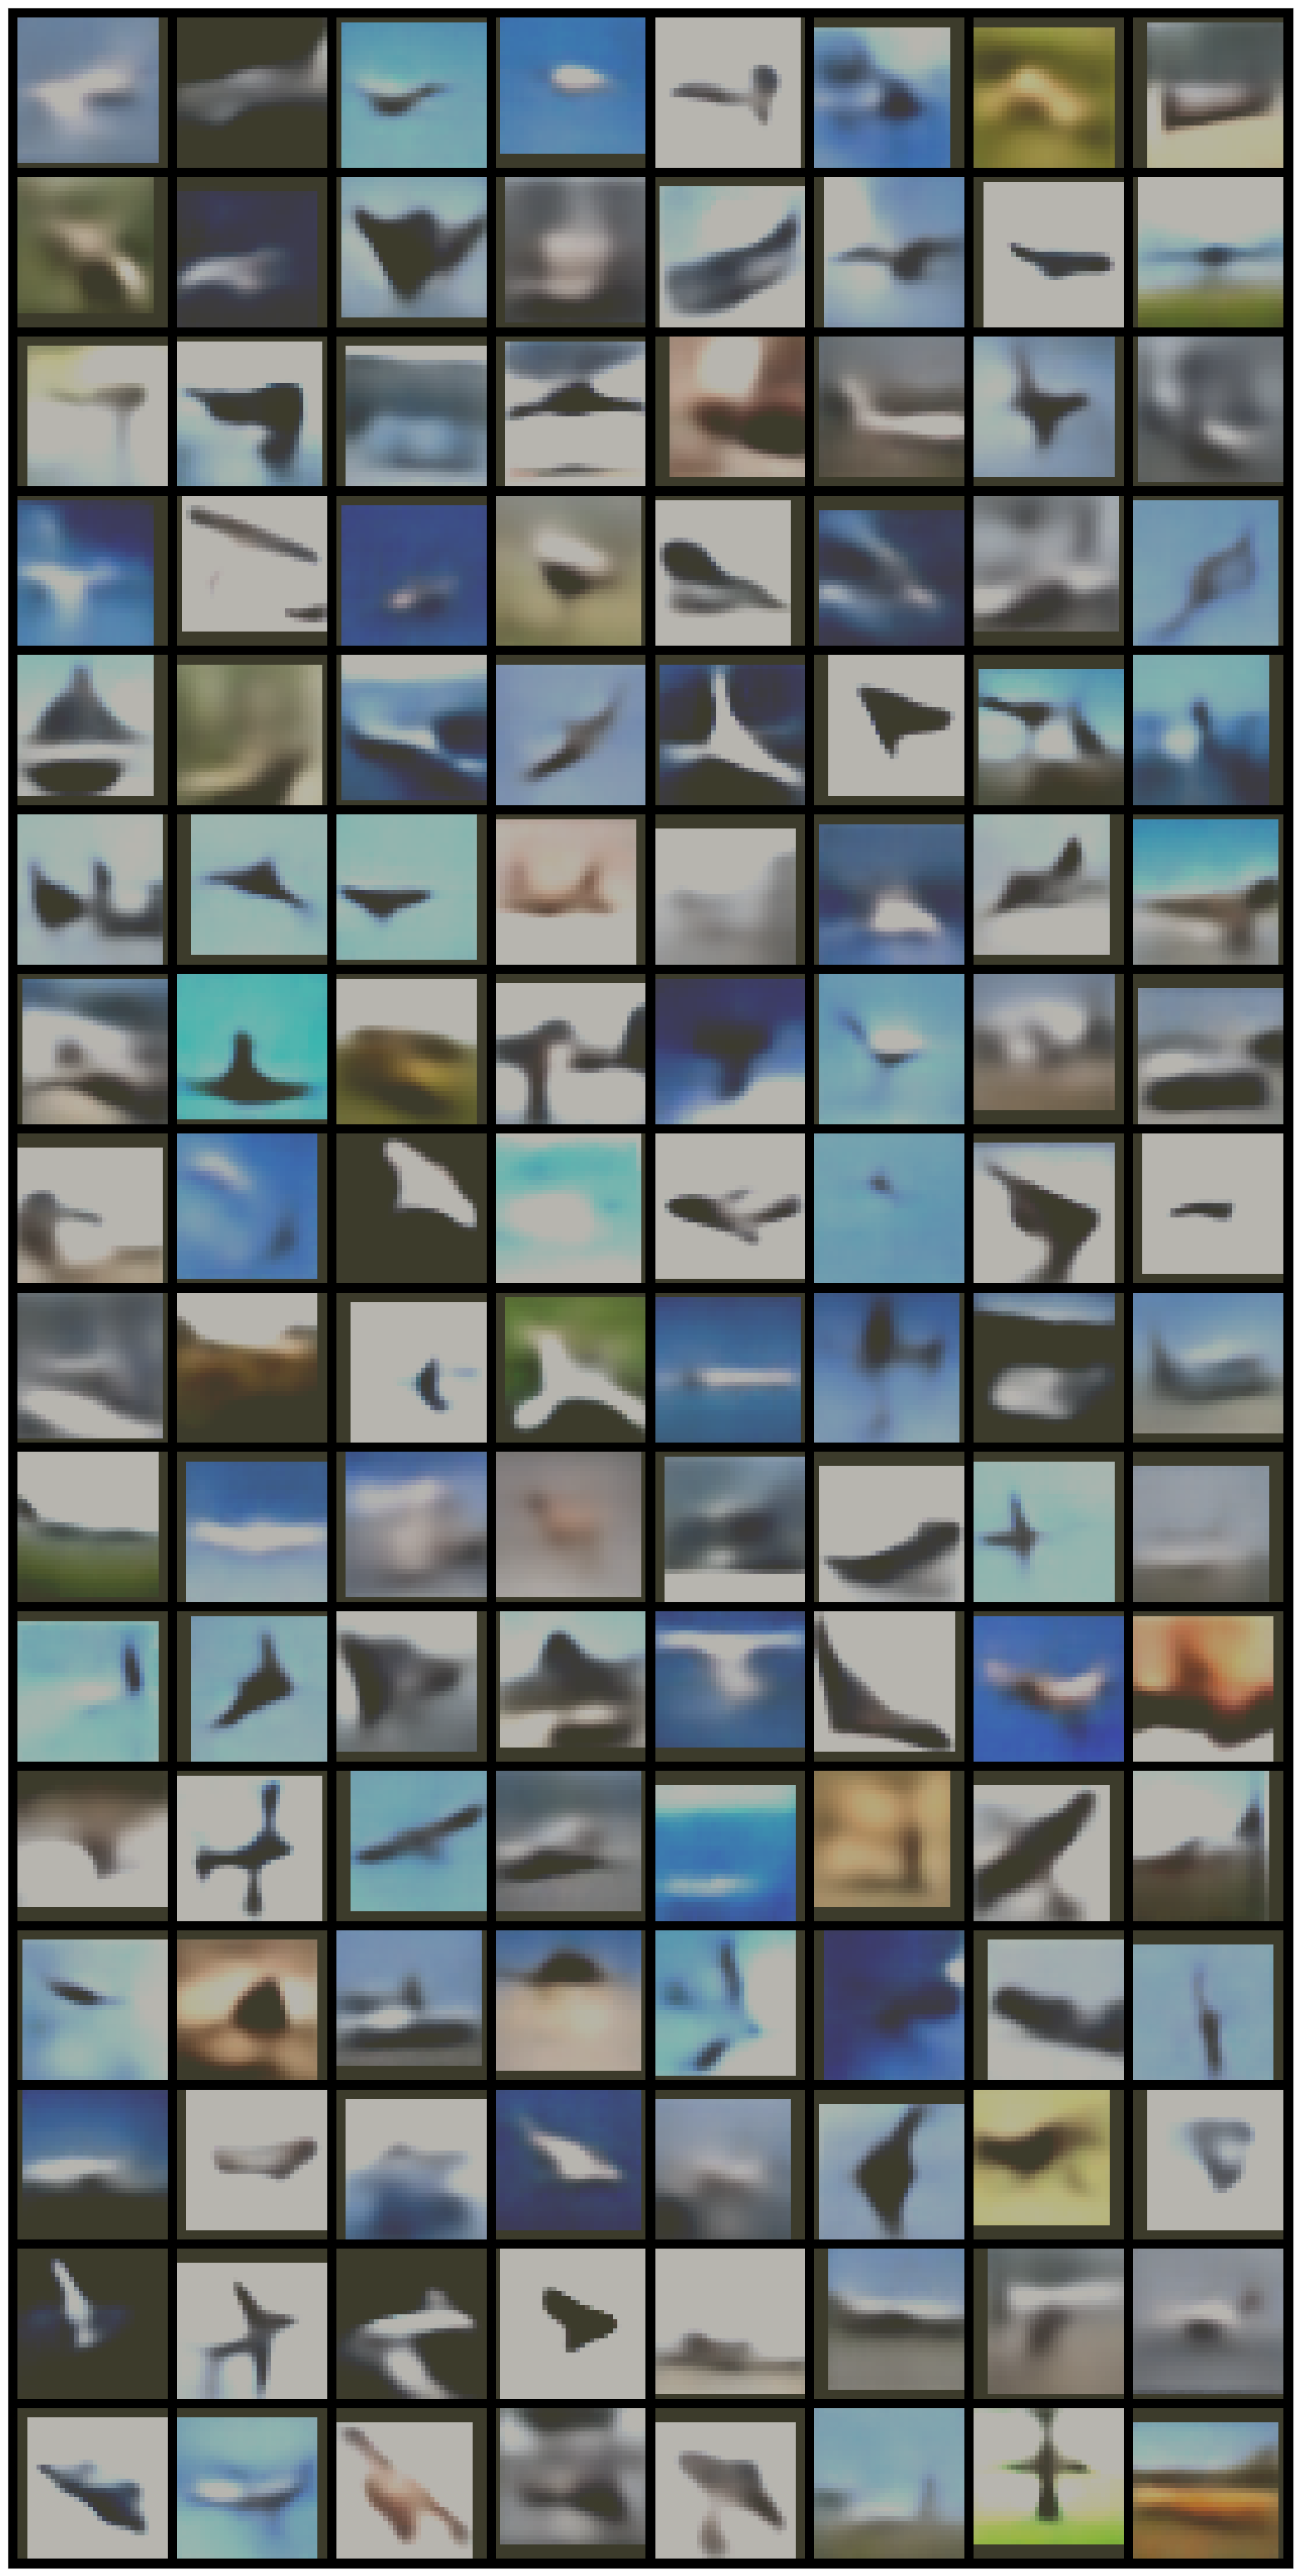

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

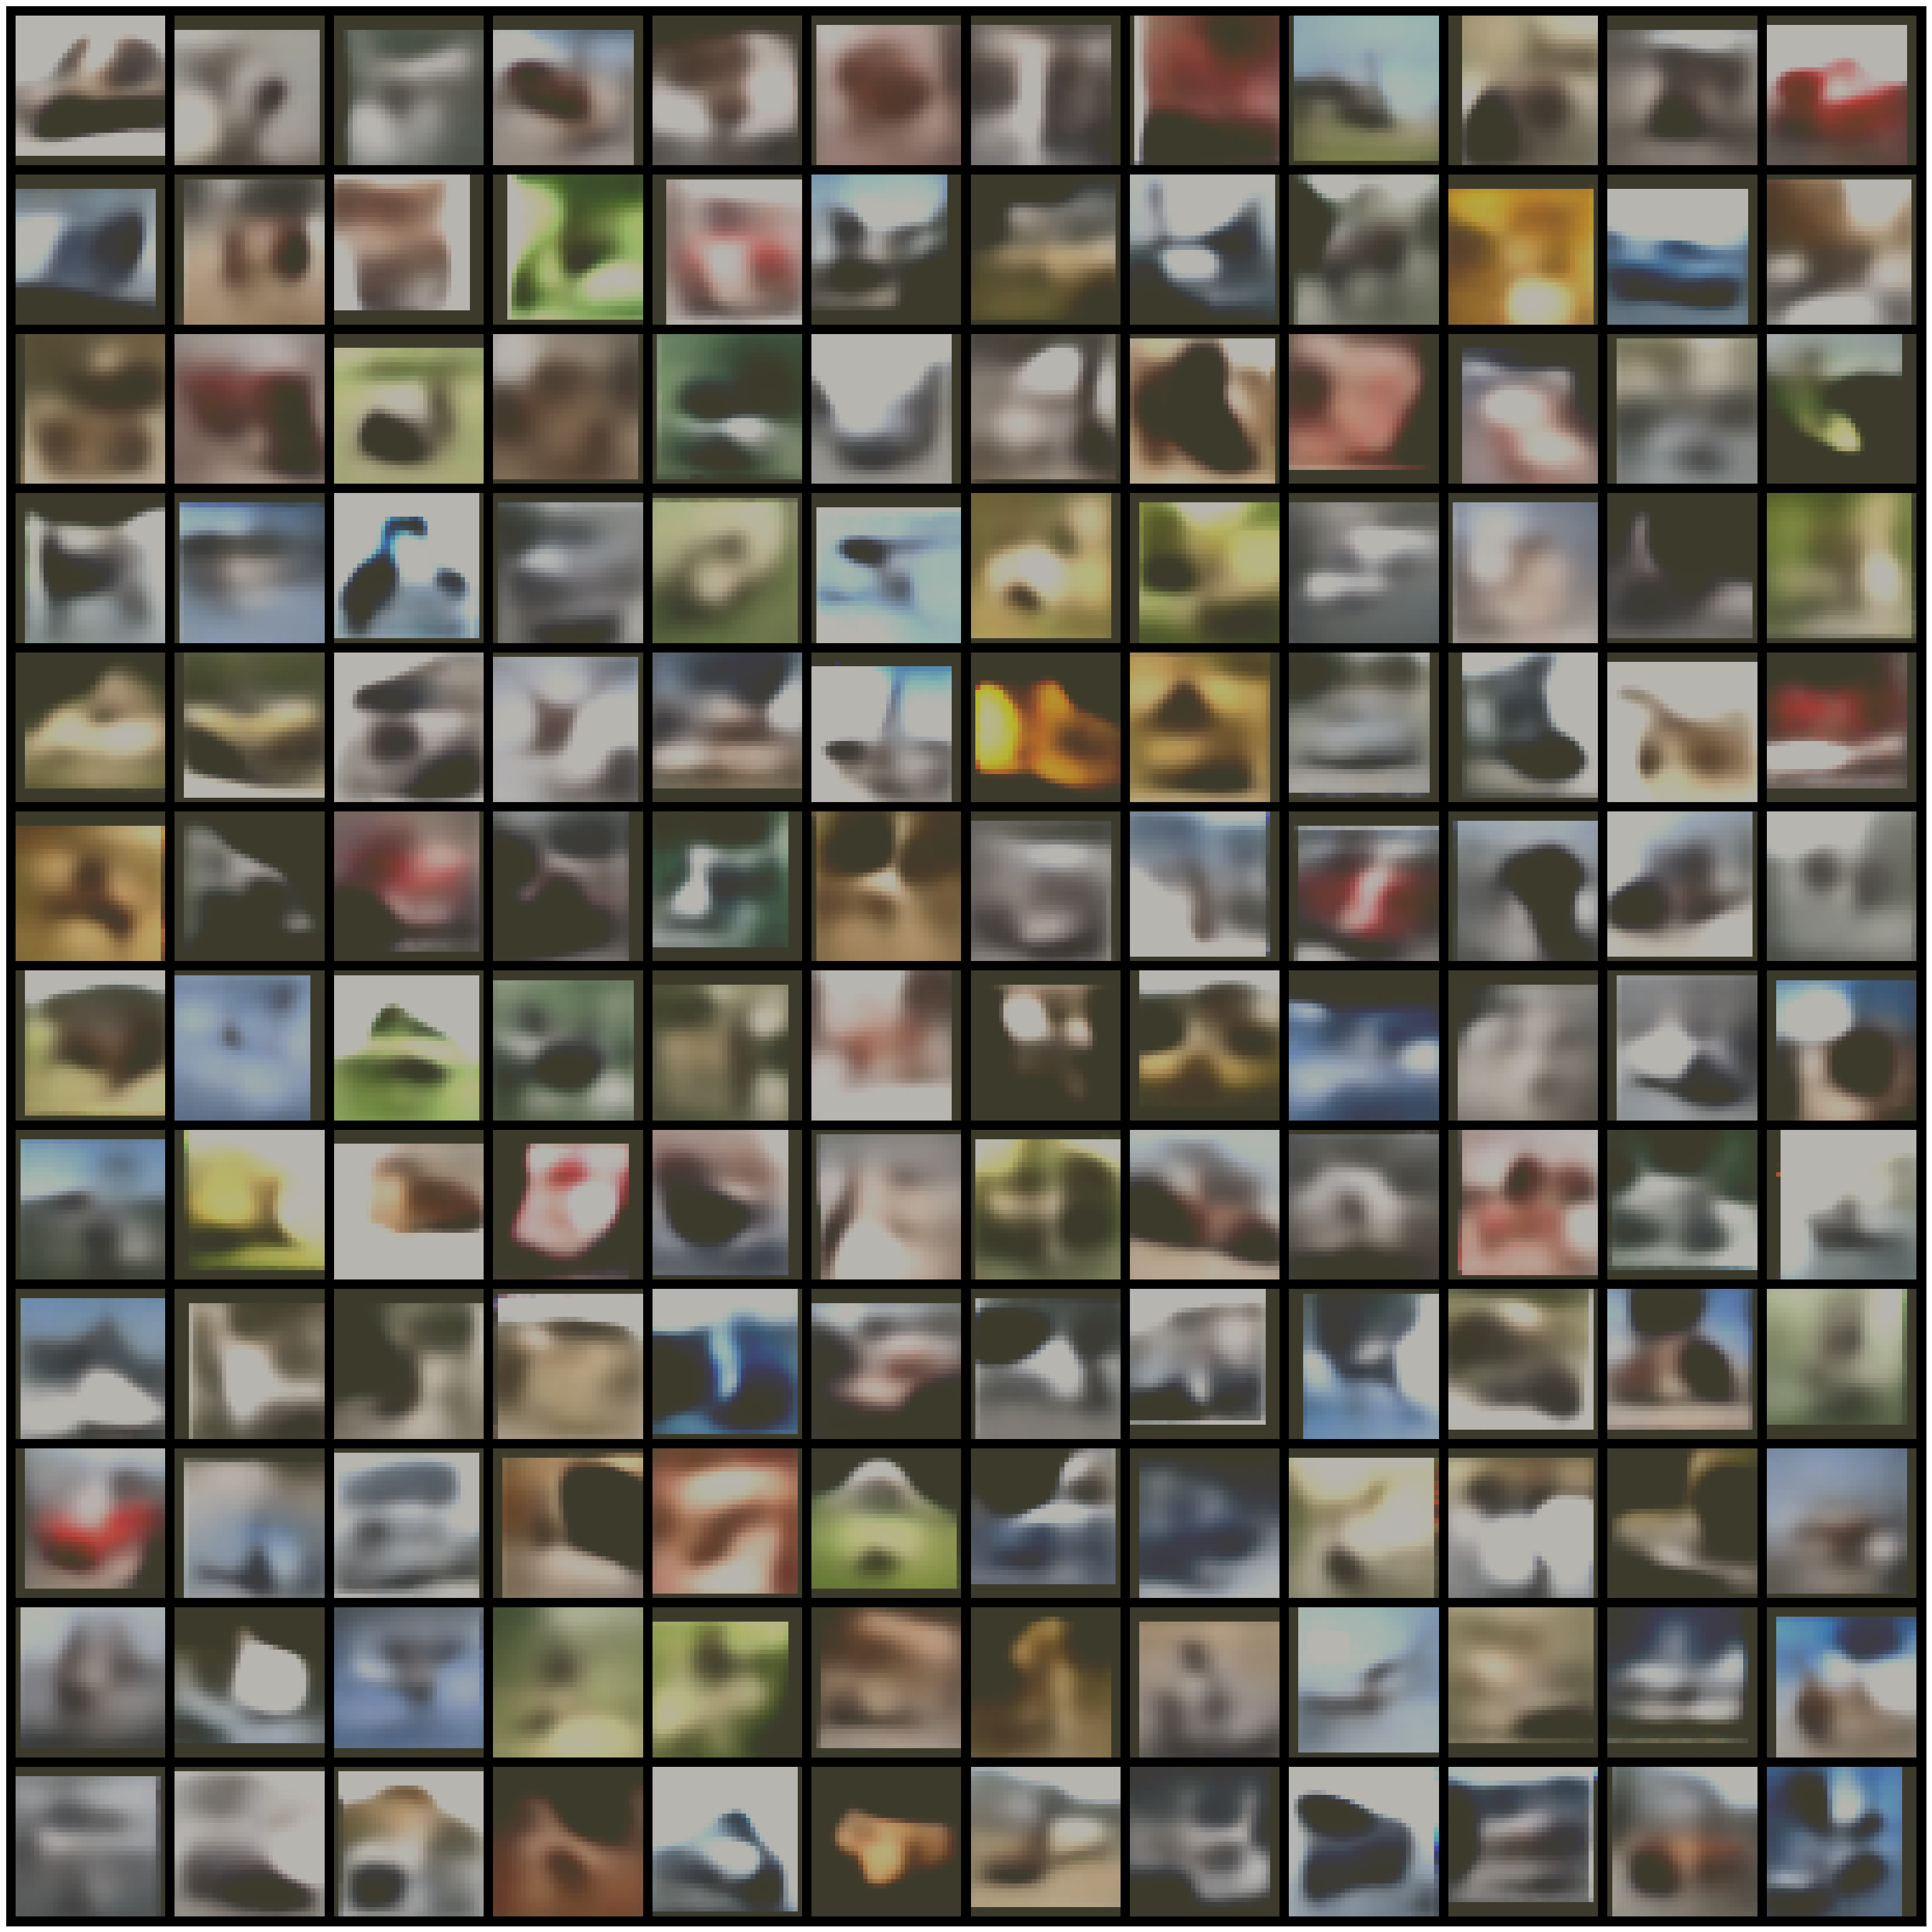

In [11]:
z = torch.randn(144, 512).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)